In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_context('poster', font_scale=1.25)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from LB_D2Q9 import pipe_cython as lb
from LB_D2Q9 import opencl_dimensionless as lb_cl

Let's setup the simulation parameters. See what our non-dimensional numbers are.

In [5]:
D = 10.**-2 # meter
rho = 1000 # kg/m^3
nu = 10.**-6. # Viscosity, m^2/s

pressure_grad = -1 # Pa/m

pipe_length = 4*D # meter

# Checking if the simulations are dimensionless

## sim 1

In [6]:
sim1 = lb_cl.Pipe_Flow(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
               N=50, two_d_local_size = (32, 32), three_d_local_size = (32, 32, 1))

Reynolds number: 39.0625
2d global: (224, 64)
2d local: (32, 32)
3d global: (224, 64, 9)
3d local: (32, 32, 1)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 7.5.23
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1610 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024, 1024, 64]
---------------------------
This context is associated with  1 devices


In [7]:
sim2 = lb_cl.Pipe_Flow(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
               N=100, two_d_local_size = (32, 32), three_d_local_size = (32, 32, 1))

Reynolds number: 39.0625
2d global: (416, 128)
2d local: (32, 32)
3d global: (416, 128, 9)
3d local: (32, 32, 1)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 7.5.23
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1610 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024, 1024, 64]
---------------------------
This context is associated with  1 devices


In [8]:
sim1.omega

0.57679999999999998

In [9]:
time_to_run = 5 # seconds

In [24]:
num_steps = int(time_to_run/sim1.delta_t)
print 'Running for', num_steps

Running for 12500


In [25]:
sim1.run(num_steps)

In [26]:
num_steps = int(time_to_run/sim2.delta_t)
print 'Running for', num_steps

Running for 50000


In [27]:
sim2.run(num_steps)

<matplotlib.colorbar.Colorbar instance at 0x7f8e9021cab8>

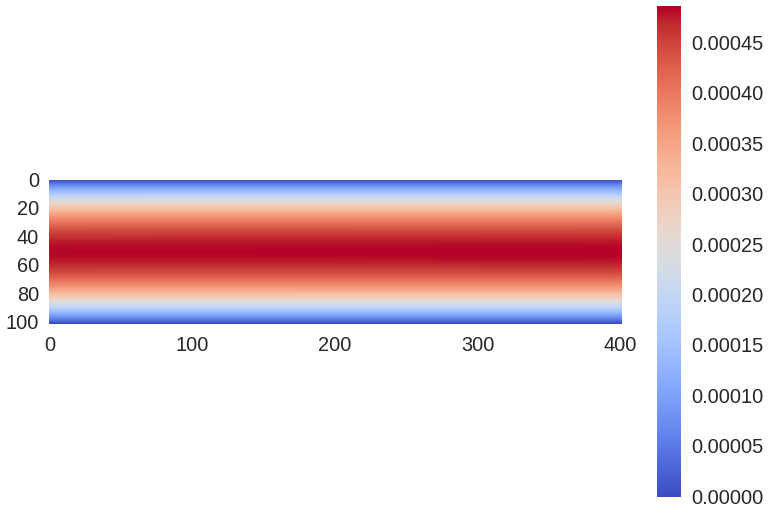

In [28]:
fields = sim2.get_physical_fields()
plt.imshow(fields['u'].T, cmap=cm.coolwarm)
plt.grid(False)

plt.colorbar()

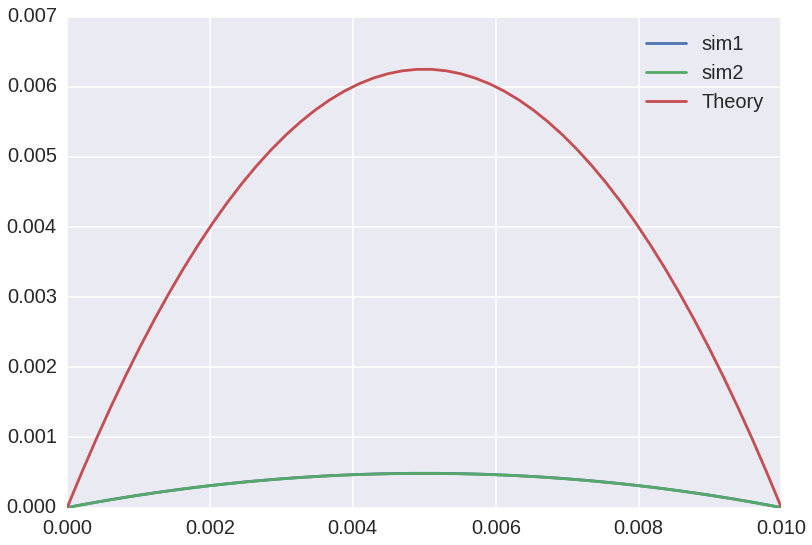

In [29]:
fields1 = sim1.get_physical_fields()
fields2 = sim2.get_physical_fields()

x_values = np.arange(fields1['u'].T.shape[0])*sim1.delta_x*sim1.L
plt.plot(x_values, fields1['u'].T[:, 200], label='sim1')

x_values = np.arange(fields2['u'].T.shape[0])*sim2.delta_x*sim2.L
plt.plot(x_values, fields2['u'].T[:, 400], label='sim2')

prefactor = (1./(4*rho*nu))*pressure_grad
r = np.linspace(-D/2, D/2)
predicted = prefactor*(r**2 - (D/2)**2)
# Convert non-dim predicted

r_shift = r + D/2
plt.plot(r_shift, predicted, label='Theory')

plt.legend(loc='best')

 So yes. The nondimensional fields are the same when we convert from simulation to simulation. *But*, they do not match our physical expectations...why.

Let's calculate the reynold's #'s of our simulation.

In [30]:
f1 = sim1.get_fields()

In [31]:
u_lb = np.max(f1['u'])
N_lb = sim1.N
nu_lb = sim1.viscosity

print (u_lb*N_lb)/nu_lb

3.05623916574


In [32]:
f2 = sim2.get_fields()

In [33]:
u_lb = np.max(f2['u'])
N_lb = sim2.N
nu_lb = sim2.viscosity

print (u_lb*N_lb)/nu_lb

3.04319701172


Ok. The reynold's #'s are the same for the two, but are not what we expect analytically, so there is something wrong. Good, making progress!

Ok. As far as I can tell, the only issue is that the system is off by a constant factor. Probably dealing with density. Changing space is ok, i.e. the net result is the same. So we are in pretty good shape overall.

In [31]:
prefactor = (1./(4*rho*nu))*pressure_grad
r = np.linspace(-D/2, D/2)
predicted = prefactor*(r**2 - (D/2)**2)

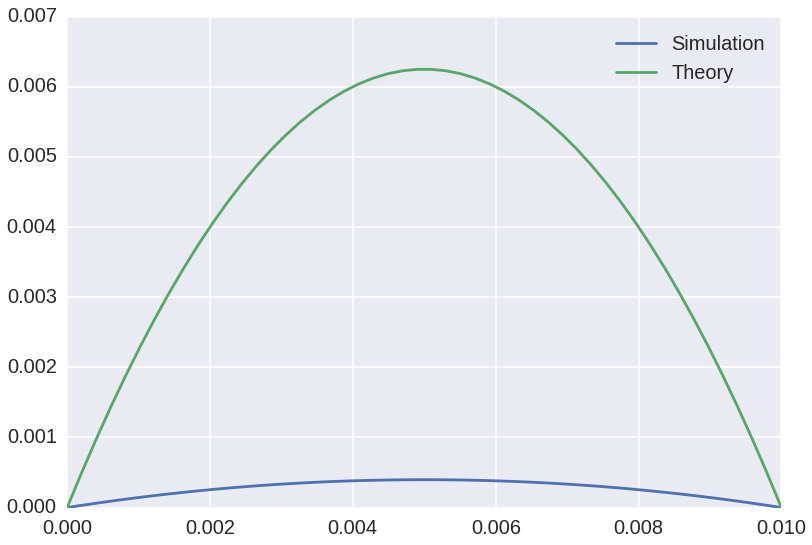

In [19]:
x_values = np.arange(fields['u'].T.shape[0])*sim.delta_x*sim.L

plt.plot(x_values, fields['u'].T[:, 400], label='Simulation')

r_shift = r + D/2
plt.plot(r_shift, predicted, label='Theory')

plt.legend(loc='best')

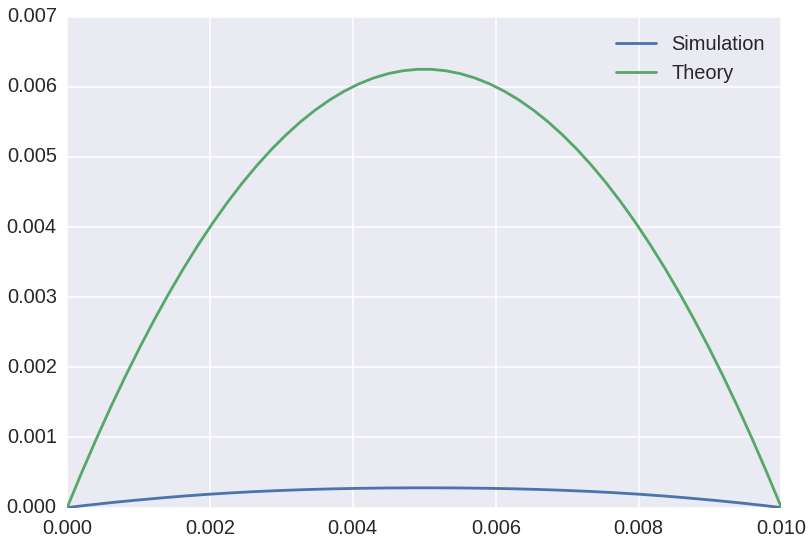

In [12]:
x_values = np.arange(fields['u'].T.shape[0])*sim.delta_x*sim.L

plt.plot(x_values, fields['u'].T[:, 400], label='Simulation')

r_shift = r + D/2
plt.plot(r_shift, predicted, label='Theory')

plt.legend(loc='best')

Hm. Units are not quite correct, as expected. Let's see if changing input gives us a different output. I expect that it will.